# FIT 5149 - Assessment 2:  Sentiment Classification for Product Reviews

Date: 27/10/2019

Group 19:
* Anup Rajesh - 29933145
* Rachana Kalachetty - 29562449
* Mohamed Hayath Mohaab Hassan - 29626889



## Table of contents

1. Introduction
2. Pre-Processing feature generation
    2.1 Pre-processing
    2.2 Feature generation
3. Models
    - 3.1 Recurrent Neural network (BOW+Bi-directional LSTM)
    - 3.2 Word embeddings with bi-directional LSTM
    - 3.3 Ensembling (Logistic Regression + SGD + Multinomial Naive Bayes
           - 3.31 Multionomial Logistic regression
           - 3.32 Stochastic Gradient Descent
           - 3.33 Multinomial Naive Bayes
4. Experimental Results 
5. Conclusion

# 1. Introduction


1. Project description: The ADA assignment-2 is about Fine-grained sentiment classification for product reviews. The dataset given to us is the product reviews provided by yelp. The dataset is divided into parts: Labeled data(50k) and unlabeled data(600k). The labeled dataset contains the product reviews under 'text' column and 'label' contains the sentiment polarity(strong negative, weak negative, neutral, weak positive, strong positive) and the unlabeled dataset contains only product reviews under 'text' column. This fine-grained sentiment classification can be used for opinion mining of reviews towards the product which in turn plays a major role in analyzing the sales, profit for a company.
2. Goal of the project: The goal of the project is to develop an machine learning algorithm which can accurately classify sentiments based on the dataset provided to us. Firstly, training the model on labeled data accurately. This model is used to predict on unlabeled datset which gives Pseudo labels as output. The new model is built which comprises of both labeled and Pseudo labeled dataset. This new model is used to predict the labels for test_data.csv provided to us.
3. Team work allocation: All 3 of us have divided the work equally. The first week of assignment realease we utlilised to research about different algorithms(supervised, semi-supervised & unsupervised) that can be applied on the yelp dataset.We did literature review on the pre-processing steps, algorithms currently used on fine-grained sentiment analysis. Each one of us took up a pre-trained algorithm to research. In the subsequent weeks each one of us tried different pre-processing steps, algorithms.In the last week, we tried optimising the algorithm by trying hyperparamter tuning on recurrent neural networks, logistic regression and SVC.

# 2. Pre-processing and feature generation

#### Import Libraries

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Word, Blobber
from nltk import ngrams
import collections
nltk.download('stopwords')
from nltk.corpus import stopwords
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [65]:
# Labeled Data
labeled_data = pd.read_csv('labeled_data.csv')

# Unlabeled Data
unlabeled_data = pd.read_csv('unlabeled_data.csv')

# Test Data
test_data = pd.read_csv('test_data.csv')

# printing labeled data
print("The labeled data is as follows: \n")
labeled_data.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


# 2.1 Pre-processing
1. Pre-processing steps on product reviews: <br>
i) Replacing all new line, carriage return characters, digits, single quotes and double quotes.<br>
Experiments: We tried considering only alphabets, negation handling, stemming or lemmatisation. But this decreased the accuarcy of the model.


#### EDA

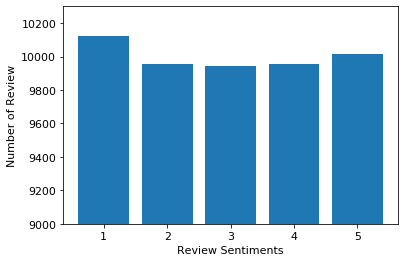

In [70]:
# visualising if all the labels are uniformly distributed - yes they are so no need for bootstrapping
label_count=labeled_data.groupby('label')['label'].count().reset_index(name ='Count')
label_count.head()
plt.bar(label_count.label.values, label_count['Count'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.ylim([9000,10300])
plt.show()

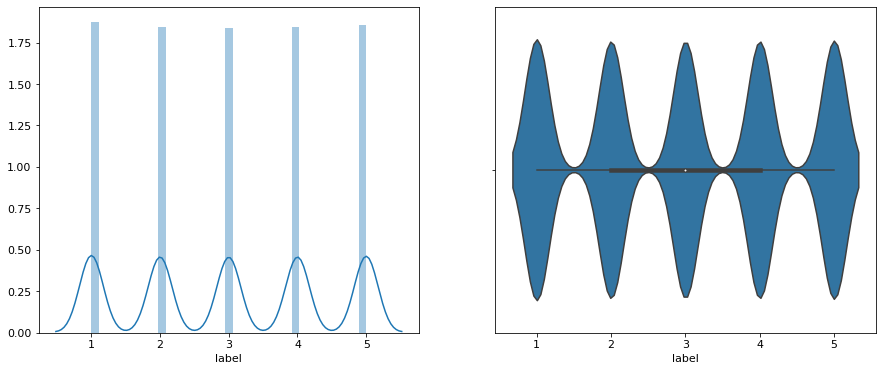

In [71]:
# Plotting label distribution

plt.figure(1 , figsize = (15 , 6))
plt.subplot(1 , 2  , 1)
sns.distplot(labeled_data['label'])
plt.subplot(1 , 2 , 2)
sns.violinplot(x = 'label' , data = labeled_data)

plt.show()

As we can see from the visualisations that all the labels are uniformly distributed.Hence, there is no need for bootstrapping or sampling to make the distribution of sentiment balanced.

In [72]:
#Frequency of top 25 most frequent words.
freq = pd.DataFrame(pd.Series(' '.join(labeled_data['text']).split()).value_counts()[:25])

In [73]:
#Resetting the index of frequency
freq=freq.reset_index()

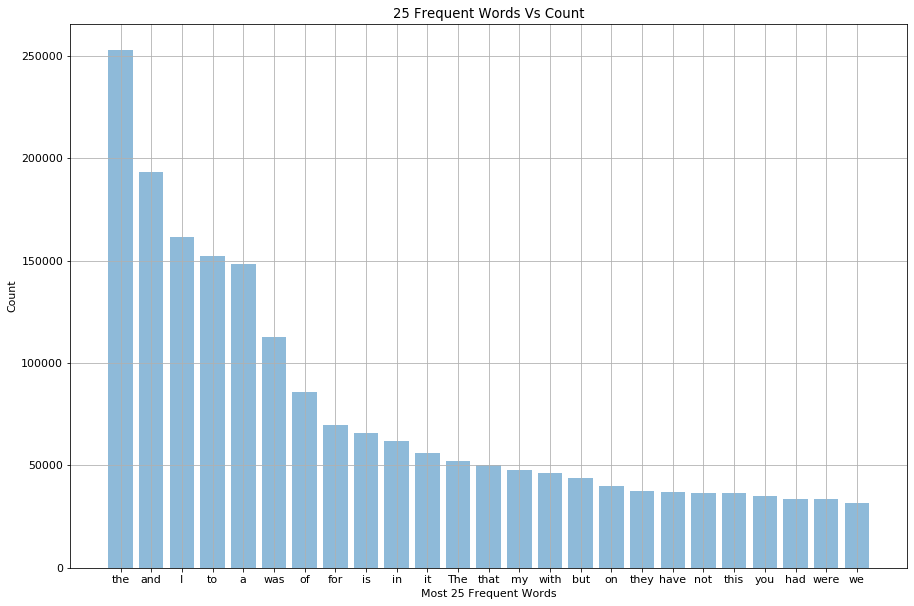

In [74]:
#Plotting the top 25 most frequent words using Matplot
plt.figure(figsize=(15,10))
plt.grid(True)
plt.bar(freq['index'], freq[0], align='center', alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Most 25 Frequent Words')
plt.title('25 Frequent Words Vs Count')
plt.rcParams.update({'font.size': 11})
plt.show()

As we can see the top 25 most frequent words seems to be stop words. But we can also see that sentence negations like 'But','not' also appear most frequently so removing stop words would be a bad options as it would decrease the confidence of predicting the sentiments.

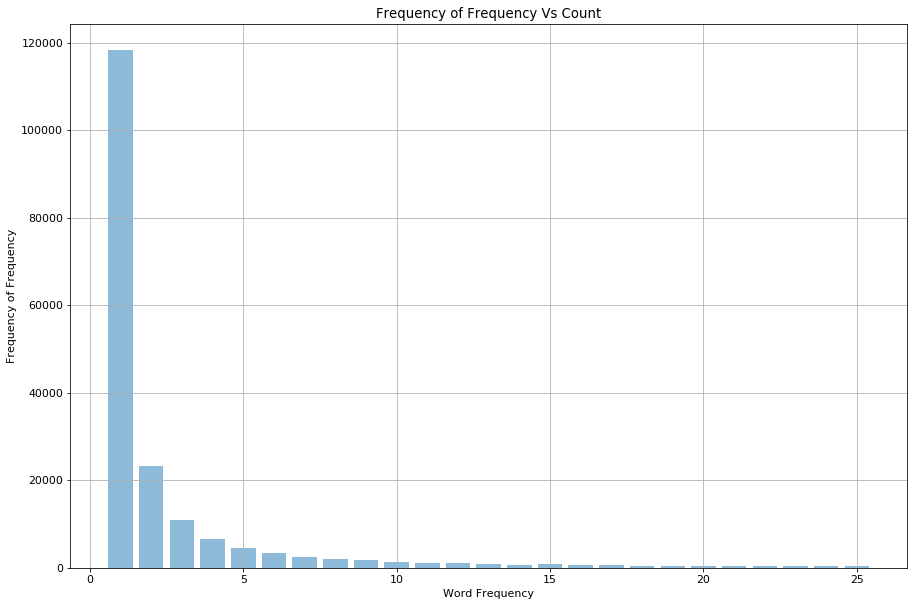

In [78]:
#Freq of all the words
freq = pd.DataFrame(pd.Series(' '.join(labeled_data['text']).split()).value_counts())

# resetting the index
freq=freq.reset_index()

# Group by the least frequent words 25
count=pd.DataFrame(freq.groupby([0]).count()[:25]).reset_index()

#plotting frequency of frequency for least words using matplot lib.
plt.figure(figsize=(15,10))
plt.grid(True)
plt.bar(count[0], count['index'], align='center', alpha=0.5)
plt.ylabel('Frequency of Frequency')
plt.xlabel('Word Frequency')
plt.title('Frequency of Frequency Vs Count')
plt.rcParams.update({'font.size': 11})
plt.show()

In [79]:
#Calculating Sentiment Polarity , Review Length and Word Count of each review.
labeled_data['Sentiment Polarity'] = labeled_data['text'].map(lambda text: TextBlob(text).sentiment.polarity)
labeled_data['Review Length'] = labeled_data['text'].astype(str).apply(len)
labeled_data['Word Count'] = labeled_data['text'].apply(lambda x: len(str(x).split()))


In [80]:
#Using Nltk Sentiment Intensity Analyser to calculate Sentiment polarity of each document
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neg_word_list=[]

#Calculating the sentiment polarity of each document and then appending into positive and negative word with the threshold value.
for word in  labeled_data['text']:
    if (sid.polarity_scores(word)['compound']) >= 0.8:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.95:
        neg_word_list.append(word)

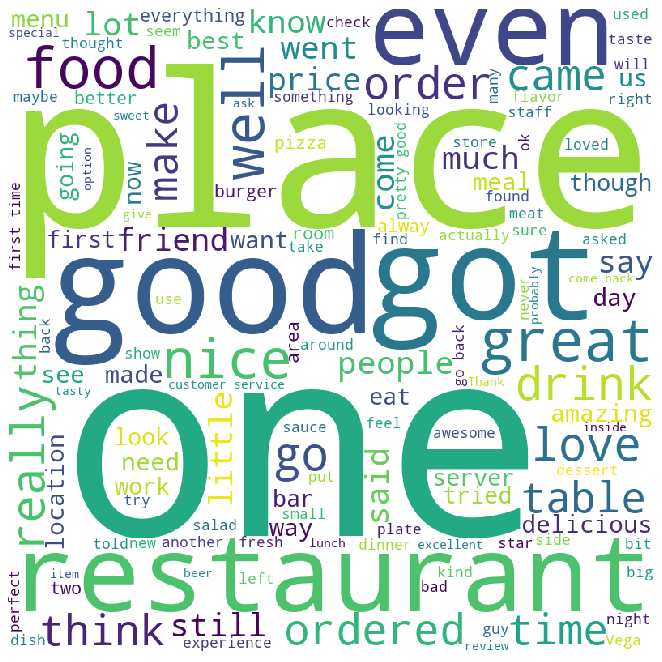

In [81]:
#Generating Word Cloud for positive phrases
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
comment_words = ' '
for words in pos_word_list: 
    comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=300,
                min_font_size = 15).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (9,12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


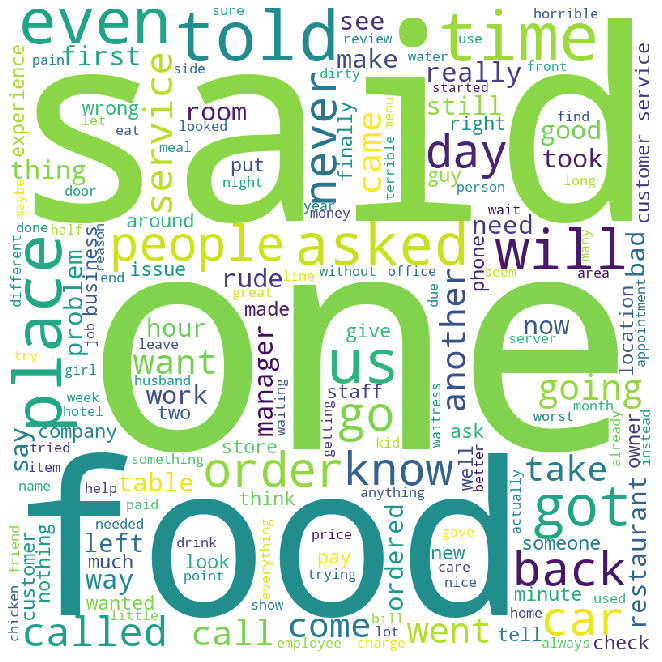

In [82]:
#Generating Word Cloud for negative phrases.
comment_words = ' '
for words in neg_word_list: 
    comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=300,
                min_font_size = 15).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12,9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Sometimes one word or even one punctuation mark influences the sentiment. 
Let's see for example most common trigrams for positive phrases

In [84]:
text = ' '.join(labeled_data.loc[labeled_data.label == 4, 'text'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]

collections.Counter(text_trigrams).most_common(30)

[(('and', 'it', 'was'), 652),
 (('a', 'lot', 'of'), 484),
 (('I', 'had', 'the'), 456),
 (('one', 'of', 'the'), 433),
 (('it', 'was', 'a'), 334),
 (('I', 'ordered', 'the'), 281),
 (('was', 'a', 'little'), 273),
 (('the', 'food', 'is'), 269),
 (('This', 'place', 'is'), 265),
 (('The', 'food', 'was'), 260),
 (('I', 'had', 'a'), 260),
 (('the', 'food', 'was'), 258),
 (('but', 'it', 'was'), 257),
 (('this', 'place', 'is'), 257),
 (('some', 'of', 'the'), 253),
 (('They', 'have', 'a'), 240),
 (('The', 'service', 'was'), 239),
 (('This', 'is', 'a'), 232),
 (('The', 'food', 'is'), 230),
 (('of', 'the', 'best'), 217),
 (('I', 'have', 'been'), 214),
 (('was', 'a', 'bit'), 205),
 (('It', 'was', 'a'), 200),
 (('is', 'a', 'great'), 199),
 (('a', 'couple', 'of'), 198),
 (('I', 'had', 'to'), 197),
 (('they', 'have', 'a'), 193),
 (('as', 'well', 'as'), 192),
 (('I', 'got', 'the'), 187),
 (('I', 'love', 'the'), 186)]

Let's remove stop words and see which are the positive phrases.

In [85]:
text = ' '.join(labeled_data.loc[labeled_data.label == 4, 'text'].values)
text = [i for i in text.split() if i not in stopwords.words('english')]
text_trigrams = [i for i in ngrams(text, 3)]
collections.Counter(text_trigrams).most_common(30)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\racha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(('I', 'would', 'definitely'), 173),
 (('I', 'would', 'recommend'), 139),
 (('I', 'highly', 'recommend'), 115),
 (('I', 'really', 'like'), 110),
 (('I', 'really', 'enjoyed'), 97),
 (('I', 'feel', 'like'), 79),
 (('My', 'husband', 'I'), 78),
 (('first', 'time', 'I'), 77),
 (('I', 'would', 'say'), 76),
 (('The', 'staff', 'friendly'), 72),
 (('I', 'really', 'liked'), 71),
 (('I', 'would', 'go'), 65),
 (('The', 'reason', 'I'), 63),
 (('I', 'think', 'I'), 61),
 (('definitely', 'go', 'back'), 56),
 (('go', 'back', 'try'), 55),
 (('I', 'would', 'like'), 55),
 (('I', 'felt', 'like'), 54),
 (('every', 'time', 'I'), 51),
 (('I', 'wish', 'I'), 50),
 (('definitely', 'come', 'back'), 48),
 (('The', 'first', 'time'), 47),
 (('would', 'definitely', 'go'), 46),
 (('next', 'time', 'I'), 46),
 (('I', 'would', 'come'), 45),
 (("I'm", 'glad', 'I'), 45),
 (('I', 'know', 'I'), 45),
 (('reason', 'I', 'give'), 44),
 (('My', 'friend', 'I'), 44),
 (('This', 'first', 'time'), 43)]

#### Pre-processing

In [111]:
# function preprocess - cleans the string or the document in this case by removing stopwords, spaces etc. and then it is
# converted to lower case.

def preprocess(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\n", "", string)              # Removing next line character with an empty space
    string = re.sub(r"\r", "", string)              # Removing carriage return character with an empty space
    string = re.sub(r"[0-9]", "", string)           # Removing the digits 
    string = re.sub(r"\'", "", string)              # Removing Single quotes
    string = re.sub(r"\"", "", string)              # Removing Double quotes
    return string.strip().lower()                   # Converting words to lowercase

#### Applying pre-processing function to the dataset

In [112]:
# the documents in df, the train dataset is processed.

for i, row in labeled_data.iterrows():
    data = str(row['text'])
    new_data = preprocess(data)
    labeled_data.set_value(i,'text',new_data)

# the documents in df, the Unlabeled  dataset is processed.

for i, row in unlabeled_data.iterrows():
    data = str(row['text'])
    new_data = preprocess(data)
    unlabeled_data.set_value(i,'text',new_data)

# the documents in df, the Test  dataset is processed.

for i, row in test_data.iterrows():
    data = str(row['text'])
    new_data = preprocess(data)
    test_data.set_value(i,'text',new_data)

C:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


KeyboardInterrupt: 

# 2.2 Feature generation

In [115]:
# Pre-processing
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

def max_length(words):
  return(len(max(words, key = len)))

def cleaning(sentences): # Training phrases in dialogflow
  words = []
  for s in sentences:
    w = word_tokenize(s.lower())
    words.append(w)
  return words  

i) The total number of documents

In [116]:
cleaned_words = cleaning(labeled_data.text)
print(len(cleaned_words))
#print(cleaned_words[:2])  

50000


ii) The size of the vocabulary 

In [58]:
from keras.preprocessing.text import Tokenizer
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Using TensorFlow backend.


Vocab Size = 103446 and Maximum length = 1021


iii) The average number of tokens of the product reviews:

In [108]:
print('Average word length of phrases in labeled is {0:.0f}.'.format(np.mean(labeled_data['text'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in unlabeled is {0:.0f}.'.format(np.mean(unlabeled_data['text'].apply(lambda x: len(x.split())))))

Average word length of phrases in labeled is 121.
Average word length of phrases in unlabeled is 122.


iv)The minimum and maximum number of tokens of the product reviews

In [109]:
min_length = len(min(cleaned_words, key = len))
print("Minimum length = %d" % ( min_length))

Minimum length = 0


As we can see the length of product reviews varies from words, sentences and paragrahs. And a product review can contain a single word or one punctuation mark can cause product review to receive a different sentiment. Also predicted sentiments can be strange/different. <br>
This EDA gives an idea about what pre-processing steps can cause noise and what features to be extracted:

* Removing stopwords can be a bad idea, especially when product reviews contain one single stopword becuase some of the stopwords like "not","but"(negation words) can change the sentiment of the product review and as seen in the visualisations ;
* puntuation could be important, so it shouldn't be removed from product reviews;
* ngrams are necessary to get the most information from data;

# 3. Models
# 3.1 Recurrent Neural network (BOW+Bi-directional LSTM)
Neural networks is inspired by the functioning of human brain.RNNs are used to make use of sequential information and understand previous outputs(Limitation in Feedforward NN).LSTM's can remember information for a long periods of time and it has three gates Forget gate, Input gate, Output gate.<br><br>
Model construction:The labeled data is pre-processed, feature generation is done by creating vocabulary and based on that vocabulary a index is given to each token and then is converted into numeric performing encoding, padding to be made suitable to feed as input to the neural network.Label of each sentiment is one hot encoded.The bi-directional LSTM model has one input layer which is fed to embedding layer with input dim= vocab size, output dimension = 128. The next layer is a bi-directional LSTM(128). This is given as input to the intermediate output layer with dimenionality of the output space same as max vocab length with activation function -'relu'. The final output layer has output space of 5(as five sentiment labels) with activation function- 'softmax'.<br>

# 3.2 Word embeddings with Bi-directional LSTM
Word embeddings(word2vec) - Word embeddings are a method of word representation that allows words with similar meaning to have a similar representation.Instead of using BOW, word embeddings is used because the BOW doesn't consider semantics of a sentence whereas word emebddings does by placing words that have similar meaning closer to each other so that the semantics/context of the sentence is not lost.It takes the context of every word as the input and tries to predict the word corresponding to the context.
Model construction:The labeled data is pre-processed, feature generation is done by creating word embeddings using Word2Vec algorithm.The text data is made suitable for feeding as input to the NN model.Label of each sentiment is one hot encoded.The bi-directional LSTM model has one input layer which is fed to embedding layer(word2vec) with input dim= vocab size, output dimension = 128. The next layer is a bi-directional LSTM(128). This is given as input to the intermediate output layer with dimenionality of the output space same as max vocab length with activation function -'relu'. The final output layer has output space of 5(as five sentiment labels) with activation function- 'softmax'.<br>

The final model we have chosen to implement in semi-supervised learning is Ensembling(Multionomial Logistic regression, Multionomial Naive Bayes and Stochastic gradient descent).

# 3.3 Ensembling (Logistic + SGD + MultinomialNB) 

Ensembling is a machine learning method that combines several base models in order to produce one optimal predictive model.Intsead of making a single model and experimenting which model is the best/most accurate predictor for the dataset, we can perform ensembling by taking a large number of models, and averaging those models to produce one final accurate model.
In our case we are using 3 models i.e. Multionomial Logistic regression, Multionomial Naive Bayes and Stochastic gradient descent. We build an ensemble model based on theses 3 models.

Here, we create the ensembling model containing a combination of three sub-models, namely Logistic Regression, Stochastic Gradient Descent and Multinomial Naive Bayes models. We combine them and build a model based on labeled data and predict it on the unlabled data for the classes where the class probabilities are higher than a threshold of 0.9 for a particular class. Then, we joined the labeled rows of unlabeled data with the labeled data itself and retrain a new model with the same parameters. Hence, we get the predict the new model on the test dataset and obtain the accuracy from Kaggle. Then, we perform alteratnions in the parameter values and perform the process again till we obtain a higher accuracy value till the model has reached a threshold point.

## 3.3.1 Multionomial Logistic regression
It is used when the dependant variable is categorical with multiple outcomes in which the log odds of the outcomes are modeled as a linear combination of the dependant variables.In our case, the sentiment labels are five so we use multinomial logistic regression intsead of binary logistic regression. From Sklearn, the logistic function along with it's parameters are given as follows,

**LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)**

From Above, we are going to be changing the the penalty term and the C value and keep the rest as the default. The penalty term is either a 'l1' or 'l2' which is used for penalization. It is Used to specify the norm used in the penalization. C is the Inverse of regularization strength or the regularization penalty parameter. We are going to be assigning random parameters till we find the optimum values which results in high accuracy. The relationship between the accuracy and the regularization parameter C is more like a gaussian distribution. We can determine the global maxima by changing the value of C considering it to be increasing along the x axis. Hence, we vary these parameters till we reach an accuracy value which won't increase.

## 3.3.2 Stochastic Gradient descent
It is an iterative algorithm, that starts from a random point on a function and travels down its slope in steps until it reaches the lowest point of that function.

**SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)**

From the above parameters, we shall keep almost everything default as it has been recommended for multiclass classification problems. But the only thing we shall change is the loss parameter from default 'hinge' to 'log'. This is because log gives a probabilistic classification and gives a logistic regression. An important reason for the use of log parameter is that, it calculates the probability of the classes for each datapoint which will be usefull for later accuracy improvement.


## 3.3.3 Multinomial Naive Bayes
Naive Bayes refers the the strong independence assumptions in the model, instead of particular distribution of each feature. It assumes that every  feature it uses are conditionally independent of one another given some class, while Multinomial Naive Bayes classifier is a variation of  Naive Bayes classifier which uses a multinomial distribution for each of the features. This works well for data which can easily be turned into counts, such as word counts in text.

**MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)** 

The only parameter we can play with is alpha. It is the smoothing parameter which has an influence on the predictions and hence the accuracy.


As we spoke about ensembling, we are going to pass in the three models above and choose VotingClassifier to help us optimise the models into the best of accuracy. Voting classifier predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

In [ ]:
# Adding the models to a list
estimators = []

# Defining Logistic Regression and its parameter
model1 = LogisticRegression(penalty = 'l2', C = 2.6, random_state=0)
# Adding the model to the list
estimators.append(('logistic', model1))

# Defining the Multinomial Naive Bayes and its parameter
model2 = MultinomialNB(alpha = 0.07, fit_prior = True)
# Adding the model to the list
estimators.append(('MultinomialNB', model2))

# Defining SGD classifier and its parameter
model3 = SGDClassifier(loss='log', penalty='l2',
                           alpha=1e-3, random_state=42, tol=None)
# Adding the model to the list
estimators.append(('SGD', model3))

# creating a voting classifier for the models
ensemble = VotingClassifier(estimators,voting='soft', weights = [0.75,0.15,0.1])

In [ ]:
# Creating list of data from labeled data
X_train = []

for i in labeled_data['text']:
    X_train.append(i)
# Creating array of labels
y_train = np.array(labeled_data["label"])

# Creating list of texts from unlabeled data as test
X_test = []

for i in unlabeled_data['text']:
    X_test.append(i)
   
   
# the final pipeline using the selected parameters and the ensemebled model
model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2),max_features=170000)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', OneVsRestClassifier(ensemble))])



# fitting the model on train labeled data and predicting on unlabeled data
model.fit(X_train, y_train)
pred = model.predict(X_test)

# Extracting the probability of classes belonging to each class into a dataframe
pred_probs = model.predict_proba(unlabeled_data['text'])
X=pred_probs>0.9               # Providing threshold of 0.9 and above

# Adding the selected columns from unlabeled data to the labeled data
final=[]
for i in range(X.shape[0]):
    val=any(X[i] == True)
    if(val):
        final.append([unlabeled_data.loc[i,'text'],pred[i]])  
             
# Concatenating labeled and selected datapoints from unlabeled data based on the threshold       
selected_unlabeled_data = pd.DataFrame (final,columns=['Text','Label'])
labeled_train=pd.DataFrame(X_train,columns=['Text'])
labeled_train_label=pd.DataFrame(y_train,columns=['Label'])
unlabeled_train_data=pd.concat([labeled_train,labeled_train_label],axis=1)

# Creating a final dataset to re-train the model
train_data=pd.concat([unlabeled_train_data,selected_unlabeled_data],axis=0)

In [ ]:
# creaing list of texts from test data
X_test = []

for i in test_data['text']:
    X_test.append(i)
   
# Fitting the model on the new data set and predicting on the test.
model.fit(list(train_data['Text']), np.array(train_data['Label']))
pred = model.predict(X_test)

# Saving the predicted values into a dataframe and saving it into a csv file for checking the accuracy
df = test_data.copy()
df['label'] = pred
df.drop(columns = 'text', inplace = True)
df.to_csv('predict_label.csv', index = False)
df.head()

# 4. Experimental results


1. Accuracy by Logistic regression:          0.60806
2. Accuracy by Multinomial Naive-Bayes:      0.55184
3. Accuarcy by Stochastic gradient descent:  0.42273
4. Accuarcy by using ensembling methods:     0.60933
5. Accuracy by using bi-directional LSTM:    0.20488

# 5. Conclusion


1. Optimal Classifier: LogisticRegression and/or Ensemble as above 
2. Best set of features used by that classifer: Bigrams and max_features. C and alpha values
3. Lessons learned from this project in regard to Sentiment Classification:
    * Complex models are not always better models. Simpler ones are capable of performing better.
    * Algorithms that take longer to compute not always result in the best of accuracies. It can mostly lead to the wrong approach if we don't know what is happening in the algorithm. 
    * Feature engineering is a better option in terms of topic modelling but it isn't the best choice when it comes to sentiment classification.
    * if Tuning parameters goes right, accuracy comes automatically. Focus on the applied part of algorithms that takes care of how the algorithm should function.


4. Suggestions for the future work: Understand feature engineering better in terms of sentiment analysis and try understanfing the parameter tuning for complex algorithms like RNN, pre-trained models etc. 